In [0]:
import numpy as np
import matplotlib.pyplot as plt
import skimage as sk
import skimage.transform
import skimage.io as skio

import torch
from torchvision import models, transforms, utils
import torch.nn as nn
from torch.autograd import Variable
import torch.optim

In [0]:
if torch.cuda.is_available():
  device = torch.device("cuda")
  tensor_type = torch.cuda.FloatTensor
else:
  device = torch.device("cpu")
  tensor_type = torch.FloatTensor
device

device(type='cuda')

In [0]:
class StyleTransferNet(torch.nn.Module):
    
    def __init__(self):
        """
        Use pre-trained VGG-19 network
        """
        super(StyleTransferNet, self).__init__()
        self.vgg = models.vgg19(pretrained=True)

    def forward(self, x):
        """
        Since we compute the loss from the outputs of each layer, 
        we process the input 1 layer at a time and return them
        """
        
        # Only keep track of convolutional layer outputs since only those
        # are used in the loss calculations
        conv_outputs = []
        
        for layer in self.vgg.features:

            # Suggested in Gatys to convert MaxPool to AvgPool
            if type(layer) == nn.modules.pooling.MaxPool2d:
                layer = nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False)

            x = layer(x)

            if type(layer) == nn.modules.conv.Conv2d:
                conv_outputs.append(x)
            
        return conv_outputs

In [0]:
def preprocess(im, shape):
    
    im = sk.transform.resize(im, shape)

    mean_vec = np.mean(im, axis=(0,1))
    std_vec = np.std(im, axis=(0,1))
    
    # Normalize all inputs before passing into model
    transform = transforms.Compose([transforms.ToTensor()])
                                # transforms.Normalize(mean=mean_vec, std=std_vec)])
    
    # Move to range [-1,1]
    im = sk.img_as_float(im)
    im = transform(im)
    
    # Model wants 4d input
    im = im.unsqueeze(0)

    return im.type(tensor_type)

In [0]:
def content_loss(content_layers, generated_out, content_out):
    
    """ 
    The Gatys paper defines a matrix for content loss, called P and F 
    for the content input p and generated image x appropriately. They are defined
    wrt each layer. They are organized as follows:
        
    [[Output of 1st filter in layer],
     [Output of 2nd filter in layer],
     ...]

    These are already given to us in the layer outputs of the parameters, and its
    dimensions are N x M.
    
    The content loss is the Sum of Squared Distances between P and F. This is
    mathematically equivalent to taking the Frobenius norm of P - F, without needing
    to flatten anything. This is becuase the Frobenius norm is row blind, i.e. 
    regardless if we flatten anything, it will just take the overall sum
    of all the squared entries.

    In practice, I used the Mean Squared Error of (P - F)^2, as it is an unbiased estimator.

    Loss = (1 / (2 * N * M)) * mean((P-F)^2)
    
    Note: Turns out stacking tensors into a list then converting that into a tensor
    is a pain. So, instead, I just utilized the fact the we are only using one layer
    in practice and just stick with that layer.
    """

    desired_layers = [layers[l] for l in content_layers]
    errors = []
    
    for l in desired_layers:
        
        content_layer, generated_layer = content_out[l], generated_out[l]
        diff = torch.mean((content_layer - generated_layer)**2)
        errors.append(0.5 * diff)

    error = sum(errors)
    
    # Using python sum over torch.sum fixed autodiff things for some reason
    return error

In [0]:
def style_loss(style_layers, generated_out, style_out, layer_weights):
    
    """
    The paper defines G (the Gram matrix), wrt to each layer, as a matrix whose ij'th entry contains the
    inner product of the i'th and j'th filter outputs:
    
    [[Inner product of 1st filter output with itself, Inner product of 1st filter output with 2nd filter output, ...],
     [Inner product of 2st filter output with 1st filter output, Inner product of 2nd filter output with itself, ...],
     ...]

    The dimensions of this matrix are N x N.
     
    Similar to content loss, we define two matrices, G and A, for the generated and style image respectively.
    Then, the style loss it Mean Squared Error between G and A. This time, when constructing G and A, we can't 
    leverage the same structure as before, so we first need to create a matrix where each row is the flattened 
    filter output, then take the inner product of this and its transpose. (If you wanted to use the Frobenius 
    norm, you would need to compute it individually for ever combination of filters, which is tedious).
    
    This is actually just the same as finding the covariance matrix where the features are the filters outputs.
    
    Loss = (1 / (4 * N * M)) * mean((A-G)^2)
    
    Finally, since this is computed across layers, we take a weighted average of these quantities. In the
    paper, they suggest using a uniform distribution of weights.

    """
    
    # Shape of layer outputs are (1, N, y, x)
    
    desired_layers = [layers[l] for l in style_layers]
    errors = []
    
    for l in desired_layers:
        
        style_layer, generated_layer = style_out[l], generated_out[l]
        _, N, y, x = style_layer.shape
        M = y * x
        
        style_feature_matrix = style_layer.squeeze().view(N, M)
        generated_feature_matrix = generated_layer.squeeze().view(N, M)
        
        A = style_feature_matrix @ style_feature_matrix.t()
        G = generated_feature_matrix @ generated_feature_matrix.t()
        # Taking the mean automatically adds everything up and divides it by N * M
        mse = (torch.mean((A - G)**2)) / (4 * N * M)
        errors.append(mse)

    weighted_errors = [layer_weights[i] * errors[i] for i in torch.arange(len(errors))]

    error = sum(weighted_errors)
        
    return error

In [0]:
def style_transfer(content_im, style_im):

  def closure():

    generated_out = net(generated_im)
    optimizer.zero_grad()
      
    # For LBFGS, closure cannot take any arguments, so make this a HOF wrapped by another func
    # with generated_im, content_out, and style_out defined there

    closs = content_loss(content_layers, generated_out, content_out)
    sloss = style_loss(style_layers, generated_out, style_out, layer_weights)

    loss = content_weight * closs + style_weight + sloss

    print("Step %s: %s" % (i, loss.cpu().item()))

    loss.backward(retain_graph=True)

    return loss

  # Preprocessing of inputs
  # If content image too big (> 1000 in any dim), resize here instead of manually
  while content_im.shape[0] > 1000 or content_im.shape[1] > 1000:
    down_sampled = (content_im.shape[0] // 2, content_im.shape[1] // 2, 3)
    content_im = sk.transform.resize(content_im, down_sampled)

  shape = content_im.shape

  content_im = preprocess(content_im, shape)
  style_im = preprocess(style_im, shape)

  # generated_im = torch.randn([1, 3, shape[0], shape[1]]).type(tensor_type).requires_grad_(True)
  generated_im = content_im.clone().requires_grad_(True)

  generated_im.to(device)
  content_im.to(device)
  style_im.to(device)

  net = StyleTransferNet()
  net.to(device)
  optimizer = torch.optim.LBFGS([generated_im], lr=1)
  # optimizer = torch.optim.Adam([generated_im])

  content_out = net(content_im)
  style_out = net(style_im)

  for i in range(500):
    optimizer.step(closure)

  return generated_im

In [0]:
layer_names = ["conv1_1", "conv1_2", 
               "conv2_1", "conv2_2", 
               "conv3_1", "conv3_2", "conv3_3", "conv3_4", 
               "conv4_1", "conv4_2", "conv4_3", "conv4_4", 
               "conv5_1", "conv5_2", "conv5_3", "conv5_4"]

# This will allow us to index into the convolutional layer outputs of the network by name, as done in the paper
layers = {layer_names[i]: i for i in torch.arange(len(layer_names))}

content_layers = ["conv5_2"]
style_layers = ["conv1_1", "conv2_1", "conv3_1", "conv4_1", "conv5_1"]

layer_weights = [0.2, 0.2, 0.2, 0.2, 0.2]

# Gatys suggests ratio of 1000:1 or 10000:1
content_weight = .1
style_weight = 1000

In [0]:
content_im = skio.imread("emma.jpg")
style_im = skio.imread("gogh.jpg")
generated_im = style_transfer(content_im, style_im)

Step 0: 1001.3196411132812
Step 0: 1001.319580078125
Step 0: 1000.5568237304688
Step 0: 1000.3037719726562
Step 0: 1000.16162109375
Step 0: 1000.0448608398438
Step 0: 1000.0298461914062
Step 0: 1000.0205688476562
Step 0: 1000.0093383789062
Step 0: 1000.0078125
Step 0: 1000.0064697265625
Step 0: 1000.0053100585938
Step 0: 1000.0049438476562
Step 0: 1000.0040893554688
Step 0: 1000.003662109375
Step 0: 1000.0033569335938
Step 0: 1000.0028076171875
Step 0: 1000.0025024414062
Step 0: 1000.0021362304688
Step 0: 1000.001953125
Step 1: 1000.0018920898438
Step 1: 1000.0017700195312
Step 1: 1000.0015869140625
Step 1: 1000.0014038085938
Step 1: 1000.001708984375
Step 1: 1000.0012817382812
Step 1: 1000.001220703125
Step 1: 1000.001220703125
Step 2: 1000.001220703125
Step 2: 1000.0011596679688
Step 2: 1000.0010375976562
Step 2: 1000.0009765625
Step 2: 1000.0009765625
Step 3: 1000.0009765625
Step 3: 1000.0009155273438
Step 3: 1000.0008544921875
Step 3: 1000.0007934570312
Step 3: 1000.0008544921875
S

In [0]:
result = generated_im.detach().cpu().squeeze(0).data
print_im = result.numpy().T

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


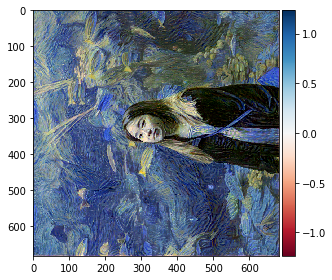

In [0]:
skio.imshow(print_im)

In [0]:
# skio.imsave("result.jpg", result)
utils.save_image(result, "result.jpg")